In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.datasets import get_rdataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# Beautiful plots
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
%matplotlib inline

# Load Airline Passengers dataset
data = get_rdataset('AirPassengers', 'datasets').data
data['time'] = pd.date_range(start='1949-01', periods=len(data), freq='M')
data.set_index('time', inplace=True)
data = data['value']
data.name = 'passengers'

print(data.head())
print(f"\nDataset: {len(data)} monthly observations from 1949 to 1960")

time
1949-01-31    112
1949-02-28    118
1949-03-31    132
1949-04-30    129
1949-05-31    121
Name: passengers, dtype: int64

Dataset: 144 monthly observations from 1949 to 1960


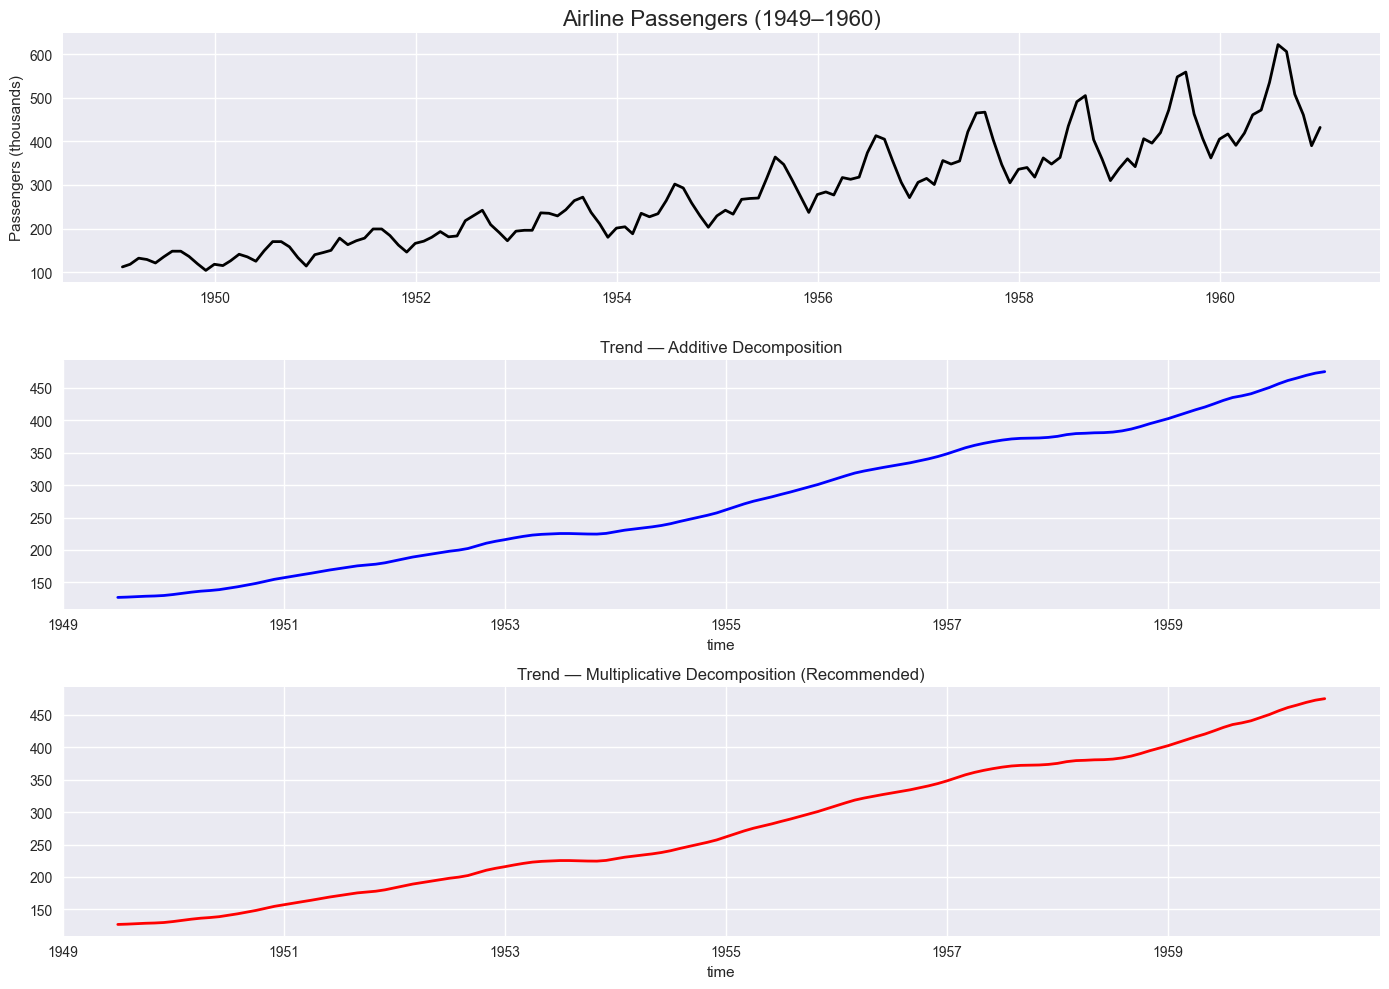

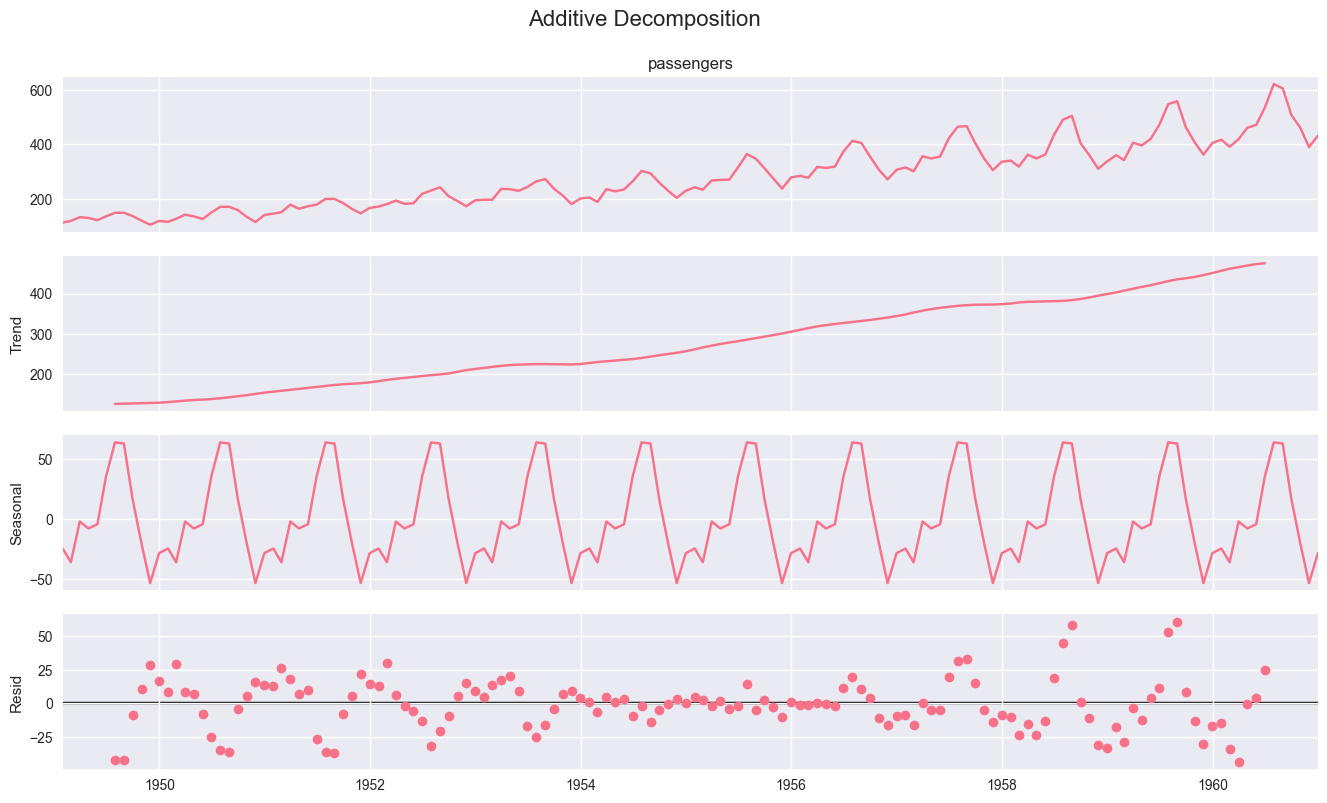

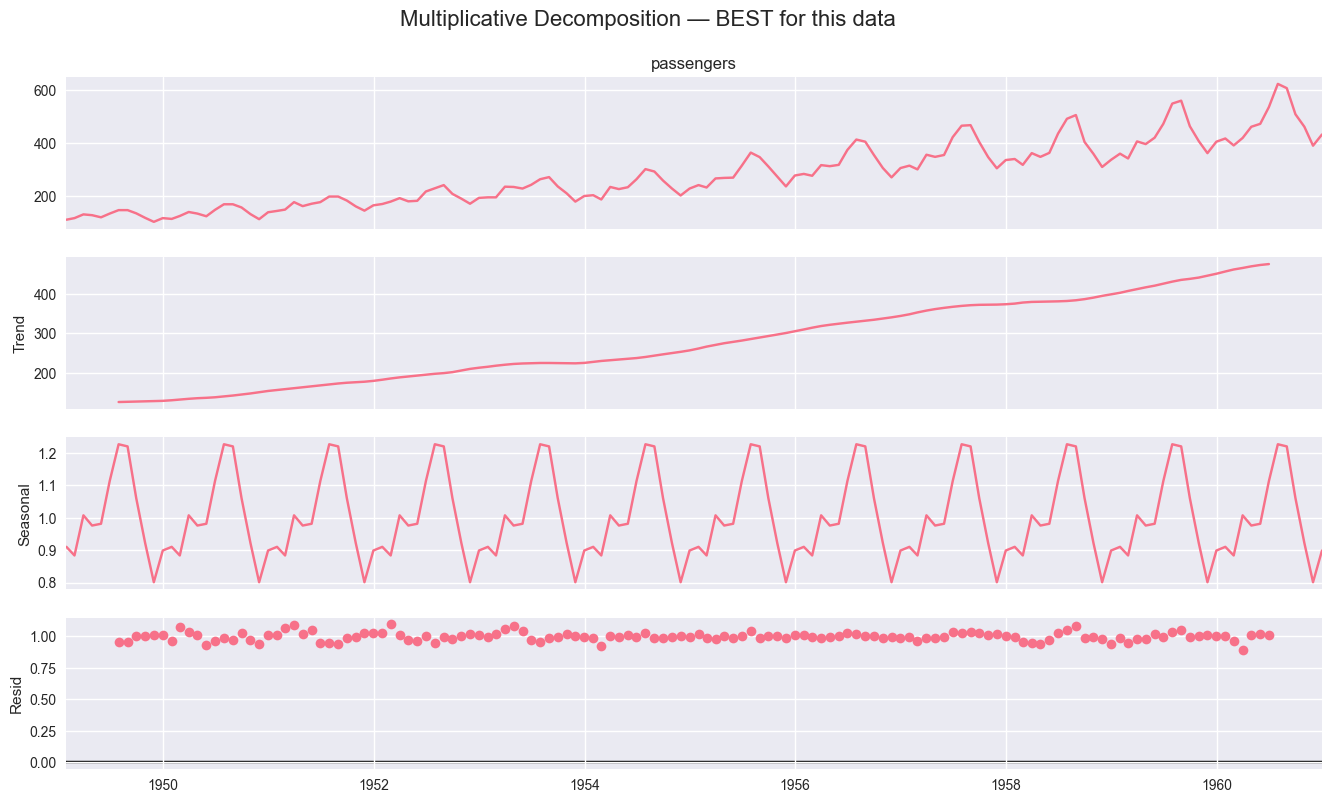

In [4]:
# Full decomposition (multiplicative is better here!)
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Original series
axes[0].plot(data, color='black', linewidth=2)
axes[0].set_title('Airline Passengers (1949–1960)', fontsize=16)
axes[0].set_ylabel('Passengers (thousands)')

# Additive decomposition trend
decomp_add = seasonal_decompose(data, model='additive', period=12)
decomp_add.trend.plot(ax=axes[1], color='blue', linewidth=2)
axes[1].set_title('Trend — Additive Decomposition')

# Multiplicative decomposition trend
decomp_mult = seasonal_decompose(data, model='multiplicative', period=12)
decomp_mult.trend.plot(ax=axes[2], color='red', linewidth=2)
axes[2].set_title('Trend — Multiplicative Decomposition (Recommended)')

plt.tight_layout()
plt.show()

# Full plots
decomp_add.plot().set_size_inches(14, 8)
plt.suptitle('Additive Decomposition', fontsize=16, y=1.02)
plt.show()

decomp_mult.plot().set_size_inches(14, 8)
plt.suptitle('Multiplicative Decomposition — BEST for this data', fontsize=16, y=1.02)
plt.show()

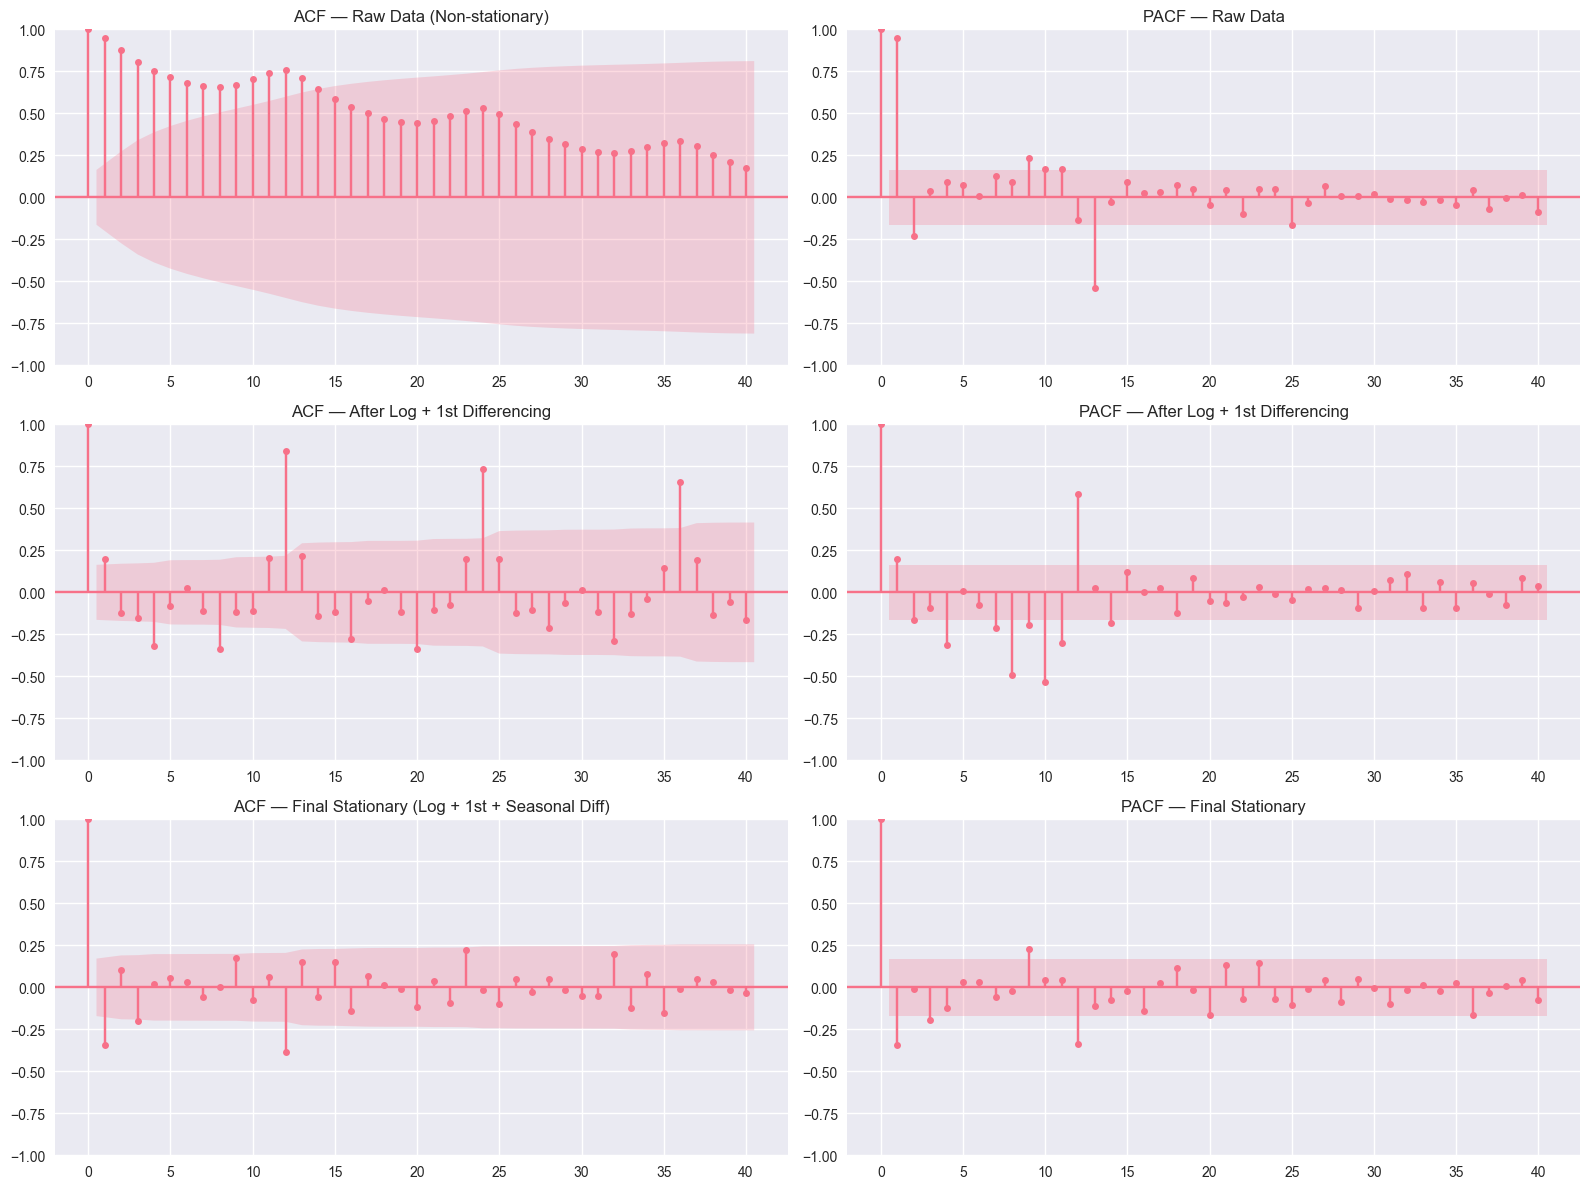

In [5]:
# Transformations
data_log = np.log(data)
data_log_diff = data_log.diff().dropna()
stationary = data_log_diff.diff(12).dropna()  # Final stationary series

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Raw data
plot_acf(data, lags=40, ax=axes[0,0], title='ACF — Raw Data (Non-stationary)')
plot_pacf(data, lags=40, ax=axes[0,1], title='PACF — Raw Data')

# After log + first differencing
plot_acf(data_log_diff, lags=40, ax=axes[1,0], title='ACF — After Log + 1st Differencing')
plot_pacf(data_log_diff, lags=40, ax=axes[1,1], title='PACF — After Log + 1st Differencing')

# Final stationary series
plot_acf(stationary, lags=40, ax=axes[2,0], title='ACF — Final Stationary (Log + 1st + Seasonal Diff)')
plot_pacf(stationary, lags=40, ax=axes[2,1], title='PACF — Final Stationary')

plt.tight_layout()
plt.show()

In [6]:
# Train-test split
train_size = int(len(data) * 0.8)
train_log = np.log(data[:train_size])
test_log = np.log(data[train_size:])
test_original = data[train_size:]

# Exogenous trend (helps ARIMAX a bit)
trend = np.arange(len(data)) / 12.0
exog_train = trend[:train_size].reshape(-1, 1)
exog_test = trend[train_size:].reshape(-1, 1)

# Fit ARIMAX (no seasonality)
arimax = SARIMAX(train_log, order=(1,1,1), exog=exog_train).fit(disp=False)

# Fit SARIMAX (with seasonality)
sarimax = SARIMAX(train_log, order=(1,1,1), seasonal_order=(1,1,1,12), exog=exog_train).fit(disp=False)

print("Models fitted successfully!")

Models fitted successfully!


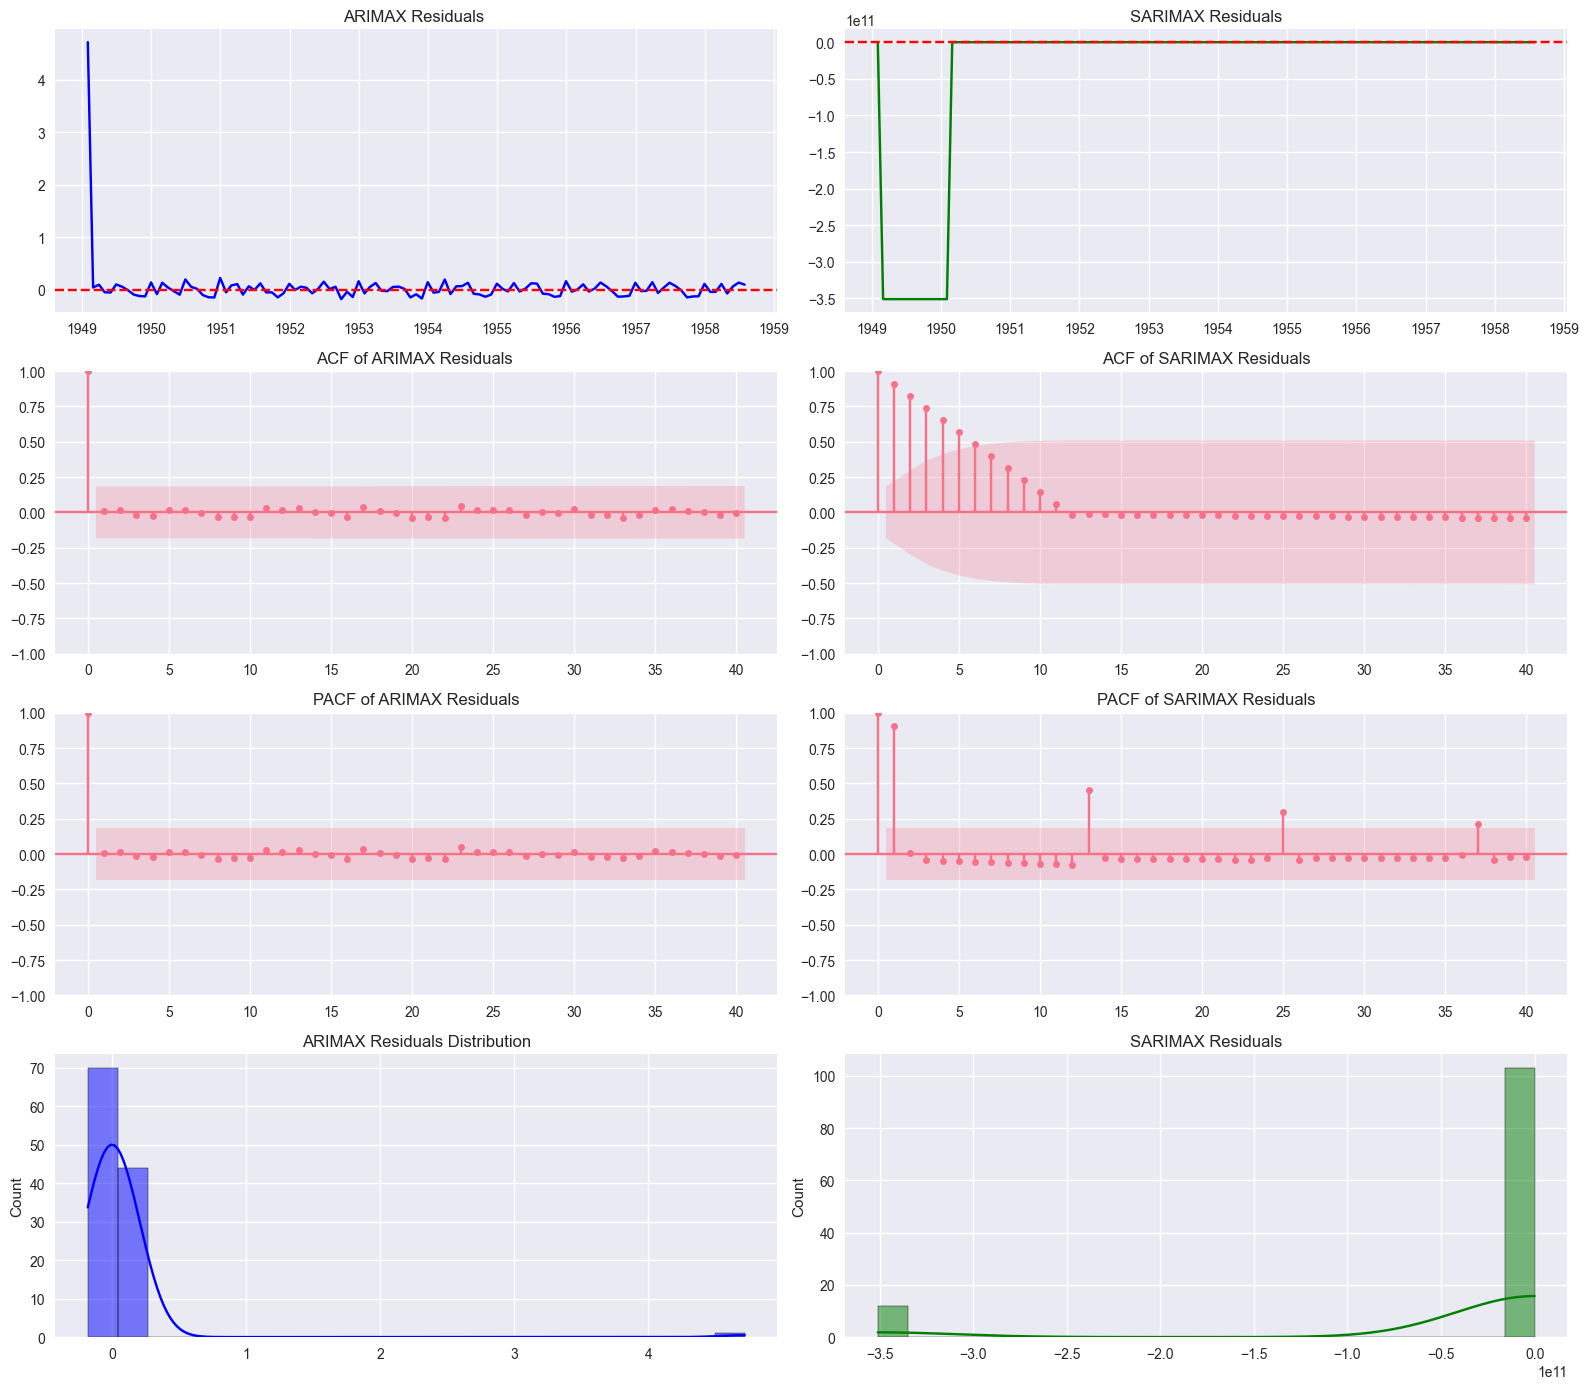

In [12]:
fig, axes = plt.subplots(4, 2, figsize=(16, 14))

# ARIMAX residuals
axes[0,0].plot(arimax.resid, color='blue')
axes[0,0].axhline(0, color='red', linestyle='--')
axes[0,0].set_title('ARIMAX Residuals ')

plot_acf(arimax.resid, lags=40, ax=axes[1,0], title='ACF of ARIMAX Residuals ')
plot_pacf(arimax.resid, lags=40, ax=axes[2,0], title='PACF of ARIMAX Residuals')
sns.histplot(arimax.resid, kde=True, ax=axes[3,0], color='blue')
axes[3,0].set_title('ARIMAX Residuals Distribution')

# SARIMAX residuals
axes[0,1].plot(sarimax.resid, color='green')
axes[0,1].axhline(0, color='red', linestyle='--')
axes[0,1].set_title('SARIMAX Residuals')

plot_acf(sarimax.resid, lags=40, ax=axes[1,1], title='ACF of SARIMAX Residuals')
plot_pacf(sarimax.resid, lags=40, ax=axes[2,1], title='PACF of SARIMAX Residuals')
sns.histplot(sarimax.resid, kde=True, ax=axes[3,1], color='green')
axes[3,1].set_title('SARIMAX Residuals')

plt.tight_layout()
plt.show()

In [8]:
# Prepare Prophet dataframe
df_prophet = pd.DataFrame({'ds': data.index, 'y': data.values})
df_prophet['cap'] = 1000   # Logistic growth (optional but nice)
df_prophet['floor'] = 0

train_p = df_prophet.iloc[:train_size]
test_p = df_prophet.iloc[train_size:]

# Fit Prophet with multiplicative seasonality
model = Prophet(
    yearly_seasonality=True,
    seasonality_mode='multiplicative',
    growth='logistic'
)
model.fit(train_p)

# Forecast
future = model.make_future_dataframe(periods=len(test_p), freq='MS')
future['cap'] = 1000
future['floor'] = 0
forecast = model.predict(future)

prophet_pred = forecast.iloc[train_size:]['yhat'].values
prophet_lower = forecast.iloc[train_size:]['yhat_lower'].values
prophet_upper = forecast.iloc[train_size:]['yhat_upper'].values

15:09:42 - cmdstanpy - INFO - Chain [1] start processing
15:09:42 - cmdstanpy - INFO - Chain [1] done processing


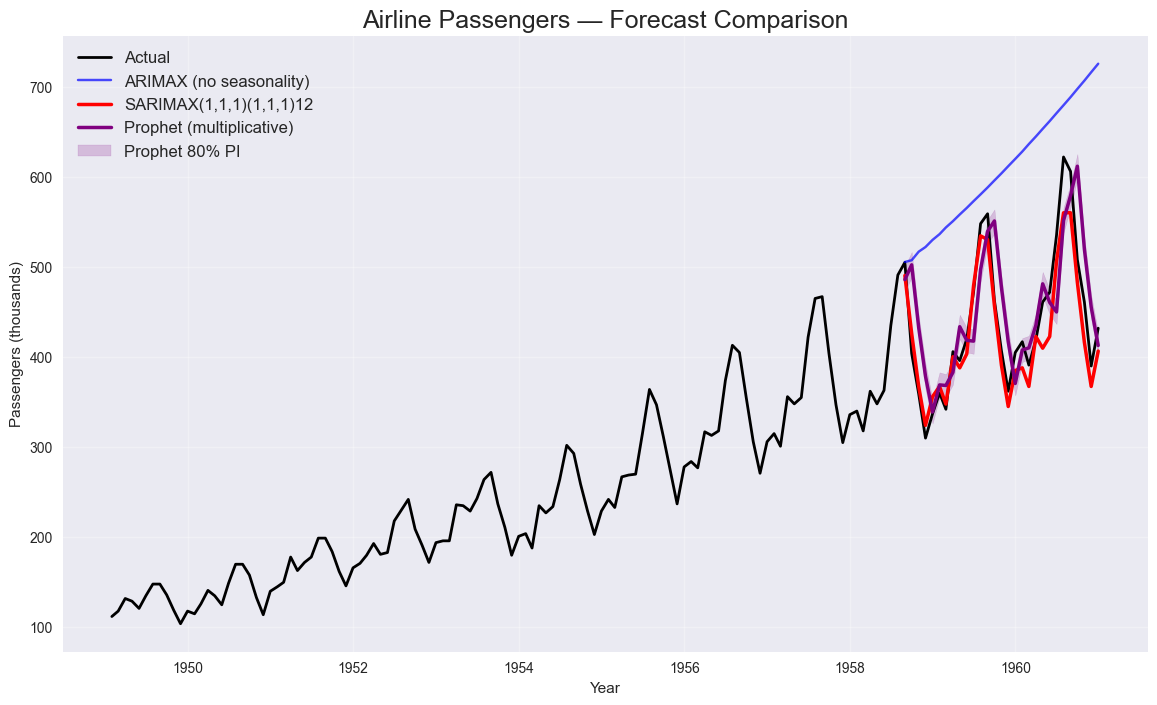

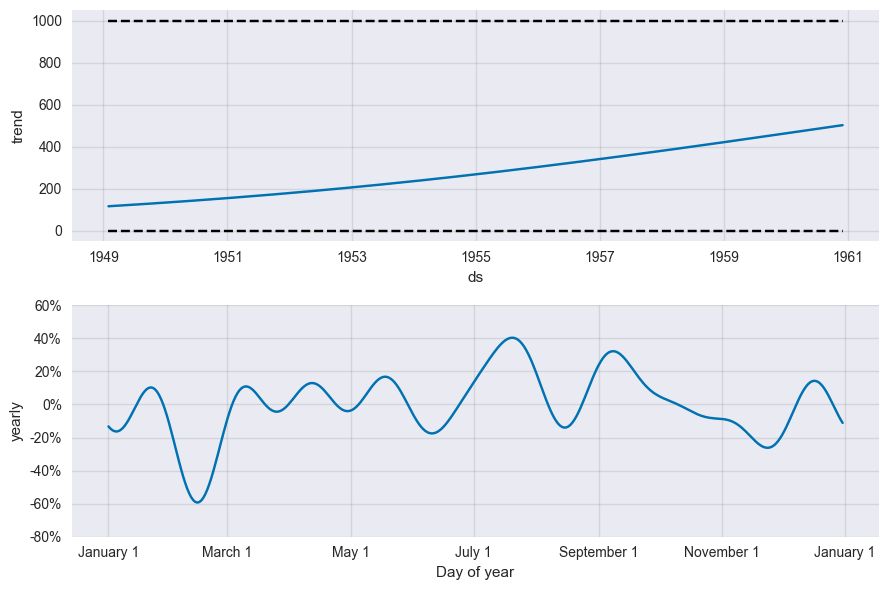

In [9]:
# Get predictions on original scale
arimax_pred = np.exp(arimax.get_forecast(steps=len(test_log), exog=exog_test).predicted_mean)
sarimax_pred = np.exp(sarimax.get_forecast(steps=len(test_log), exog=exog_test).predicted_mean)

plt.figure(figsize=(14, 8))
plt.plot(data.index, data, label='Actual', color='black', linewidth=2)
plt.plot(test_original.index, arimax_pred, label='ARIMAX (no seasonality)', color='blue', alpha=0.7)
plt.plot(test_original.index, sarimax_pred, label='SARIMAX(1,1,1)(1,1,1)12', color='red', linewidth=2.5)
plt.plot(test_original.index, prophet_pred, label='Prophet (multiplicative)', color='purple', linewidth=2.5)
plt.fill_between(test_original.index, prophet_lower, prophet_upper, color='purple', alpha=0.2, label='Prophet 80% PI')
plt.title('Airline Passengers — Forecast Comparison', fontsize=18)
plt.xlabel('Year')
plt.ylabel('Passengers (thousands)')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Prophet components
fig = model.plot_components(forecast)
plt.show()

In [10]:
def metrics(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred))
    }

results = pd.DataFrame({
    'Model': ['ARIMAX', 'SARIMAX', 'Prophet'],
    'MAE': [metrics(test_original, arimax_pred)['MAE'],
            metrics(test_original, sarimax_pred)['MAE'],
            metrics(test_original, prophet_pred)['MAE']],
    'RMSE': [metrics(test_original, arimax_pred)['RMSE'],
             metrics(test_original, sarimax_pred)['RMSE'],
             metrics(test_original, prophet_pred)['RMSE']]
})

print("FINAL MODEL COMPARISON")
print("="*50)
print(results.round(2))
print("\nWinner: Prophet (easiest + best fit due to multiplicative seasonality)")
print("Runner-up: SARIMAX(1,1,1)(1,1,1)[12] — excellent if you need statistical rigor")

FINAL MODEL COMPARISON
     Model     MAE    RMSE
0   ARIMAX  167.21  183.93
1  SARIMAX   22.12   26.82
2  Prophet   42.67   52.11

Winner: Prophet (easiest + best fit due to multiplicative seasonality)
Runner-up: SARIMAX(1,1,1)(1,1,1)[12] — excellent if you need statistical rigor
